In [1]:
##Step 1: Imports

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestRegressor


In [2]:
##Step 2: Config

RANDOM_STATE = 42
TEST_SIZE = 0.20
N_ESTIMATORS = 500
CV_FOLDS = 5
PERM_REPEATS = 20

TARGET_COL = "print_run"

DROP_COLS = [
    "print_run",
    "card_id",
    "release_date",
    "player",
    "description"
]

path = r"C:\Topps Now\NBA\nba_toppsnow.xlsx"

In [3]:
##Step 3: Load Data

df = pd.read_excel(path)

print("Rows:", len(df))
print("Columns:", df.shape[1])
df.head()

Rows: 170
Columns: 34


,card_id,sport,set_name,year,card_num,release_date,player,team,status,print_run,...,has_auto_relic,green_99,gold_50,orange_25,black_10,red_5,foilfractor_1,parallel_count,has_any_parallel,description
0,1,NBA,Topps Now,2025,1,2025-10-21,Shai Gilgeous-Alexander,Oklahoma City Thunder,Vet,7695.0,...,0,1,1,1,1,1,1,6,1,MVP's 35 Points Power 2OT Opening Night Win
1,2,NBA,Topps Now,2025,2,2025-10-21,Oklahoma City Thunder,Oklahoma City Thunder,Vet,4033.0,...,0,1,1,1,1,1,1,6,1,Raise 1st NBA Championship Banner IN OKC Ahead...
2,3,NBA,Topps Now,2025,3,2025-10-21,Kevin Durant,Houston Rockets,Vet,1673.0,...,0,1,1,1,1,1,1,6,1,Vintage Form In Rockets Debut With 23-Point Game
3,4,NBA,Topps Now,2025,4,2025-10-21,Alperen Sengun,Houston Rockets,Vet,1135.0,...,0,1,1,1,1,1,1,6,1,1st Player In NBA History With 35/5/5/5 Line I...
4,5,NBA,Topps Now,2025,5,2025-10-21,Luka Doncic,Los Angeles Lakers,Vet,7591.0,...,0,1,1,1,1,1,1,6,1,Joins Lakers Royalty With 43 Pts In 1st LA Opener


In [4]:
##Step 4: Quality Control Checks

print("Missing print_run:", df[TARGET_COL].isna().sum())
print("Duplicate card_id:", df["card_id"].duplicated().sum())

print("\nPrint Run Summary:")
print(df[TARGET_COL].describe())

print("\nTop 5 Highest Print Runs:")
print(df.sort_values(TARGET_COL, ascending=False)[[TARGET_COL]].head())

print("\nBottom 5 Lowest Print Runs:")
print(df.sort_values(TARGET_COL)[[TARGET_COL]].head())


Missing print_run: 6
Duplicate card_id: 0

Print Run Summary:
count      164.000000
mean      3629.042683
std       8096.468382
min        391.000000
25%        683.500000
50%       1141.000000
75%       2809.000000
max      67580.000000
Name: print_run, dtype: float64

Top 5 Highest Print Runs:
     print_run
151    67580.0
5      43182.0
85     42224.0
57     30683.0
149    30039.0

Bottom 5 Lowest Print Runs:
     print_run
160      391.0
63       401.0
116      406.0
117      410.0
34       418.0


In [5]:
##Step 5: Build df_model, Define X and y (Log Target)
#Create Modeling Dataset + Define Features/Target

# Keep only rows with known print_run
df_model = df[df[TARGET_COL].notna()].copy()

print("Rows used for modeling:", len(df_model))

# Log-transform target
y = np.log1p(df_model[TARGET_COL])

# Drop leakage + unnecessary columns
X = df_model.drop(columns=DROP_COLS)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Identify feature types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric feature count:", len(numeric_features))
print("Categorical feature count:", len(categorical_features))


Rows used for modeling: 164
X shape: (164, 29)
y shape: (164,)
Numeric feature count: 25
Categorical feature count: 4


In [6]:
##Step 6: Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("Train target mean (log):", round(y_train.mean(), 3))
print("Test target mean (log):", round(y_test.mean(), 3))



Train shape: (131, 29)
Test shape: (33, 29)
Train target mean (log): 7.367
Test target mean (log): 7.221


In [7]:
##Step 7: Build the Preprocessing and Random Forest Pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=N_ESTIMATORS,
        random_state=RANDOM_STATE
    ))
])

print("Pipeline built.")

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))



Pipeline built.
Numeric features: 25
Categorical features: 4


In [8]:
##Step 8: Fit the Model

model.fit(X_train, y_train)
print("Model fit complete.")

Model fit complete.


In [9]:
## Step 9: Evaluate Holdout (convert back from log space)

# Predict in log space
y_pred_log = model.predict(X_test)

# Convert back to original scale
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# Metrics (original scale)
mae = mean_absolute_error(y_actual, y_pred)
mape_median = np.median(np.abs((y_actual - y_pred) / y_actual))

print("OOS MAE:", round(mae, 2))
print("Median % Error:", round(mape_median, 3))

#Worst Misses table
results = X_test.copy()
results["actual_print_run"] = y_actual
results["pred_print_run"] = y_pred
results["abs_error"] = np.abs(results["actual_print_run"] - results["pred_print_run"])
results["pct_error"] = results["abs_error"] / results["actual_print_run"]

results.sort_values("abs_error", ascending=False).head(10)[
    ["actual_print_run", "pred_print_run", "abs_error", "pct_error"]
]


OOS MAE: 1339.24
Median % Error: 0.265


,actual_print_run,pred_print_run,abs_error,pct_error
85,42224.0,21253.314650,20970.685350,0.496653
9,2103.0,6656.352727,4553.352727,2.165170
66,14329.0,10035.833157,4293.166843,0.299614
18,13527.0,11432.713103,2094.286897,0.154823
95,3882.0,2590.408816,1291.591184,0.332713
115,4266.0,3046.216974,1219.783026,0.285931
162,709.0,1774.443635,1065.443635,1.502741
133,3821.0,2808.830328,1012.169672,0.264897
30,740.0,1668.993564,928.993564,1.255397
12,508.0,1151.688982,643.688982,1.267104


In [10]:
##Step 10: Cross-Validation (log space)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=CV_FOLDS,
    scoring="neg_mean_absolute_error"
)

cv_mae = -cv_scores  # convert from negative

print("Fold MAEs (log):", np.round(cv_mae, 2))
print("Average CV MAE (log):", round(cv_mae.mean(), 2))
print("Std Dev:", round(cv_mae.std(), 2))


Fold MAEs (log): [0.6  0.41 0.37 0.49 0.7 ]
Average CV MAE (log): 0.51
Std Dev: 0.12


In [11]:
##Step 11: Permutation Importance (business-level features)

perm = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=PERM_REPEATS,
    random_state=RANDOM_STATE,
    scoring="neg_mean_absolute_error"
)

perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance", ascending=False)

perm_df.head(20)


,feature,importance,importance_std
17,team_tier,0.245854,0.045931
4,team,0.220023,0.047018
20,has_auto_relic,0.218966,0.053600
16,is_superstar,0.159464,0.037356
3,card_num,0.051126,0.022344
5,status,0.010842,0.016004
11,rc_count,0.009475,0.006385
10,is_rookie,0.007872,0.006596
12,is_vet,0.007166,0.006302
19,has_sp,0.006768,0.004529


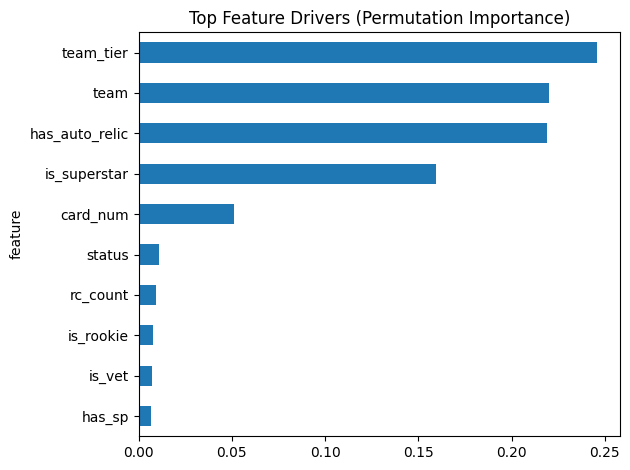

In [12]:
##Step 12: Visual

perm_df.head(10).sort_values("importance").plot(
    x="feature",
    y="importance",
    kind="barh",
    legend=False
)

plt.title("Top Feature Drivers (Permutation Importance)")
plt.tight_layout()
plt.show()
